In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from stochastic_simulation.approximation import approximate, predictor_corrector_approximate, kps_approximate
from stochastic_simulation.models import *
from stochastic_simulation.wiener import generate

In [4]:
methods = {
    "euler": lambda kwargs: approximate(method='euler', **kwargs),
    "milstein1": lambda kwargs: approximate(method='milstein1', **kwargs),
    "milstein2": lambda kwargs: approximate(method='milstein2', **kwargs),
    "pred_corr": lambda kwargs: predictor_corrector_approximate(**kwargs),
}

In [5]:
brownian = BrownianMotion(x_0=10, theta_1=1, theta_2=0.5)
cir = CoxIngersollRoss(x_0=10, theta=3, beta=2, sigma=2)

models = {
    'brownian': brownian,
    'cir': cir,
}

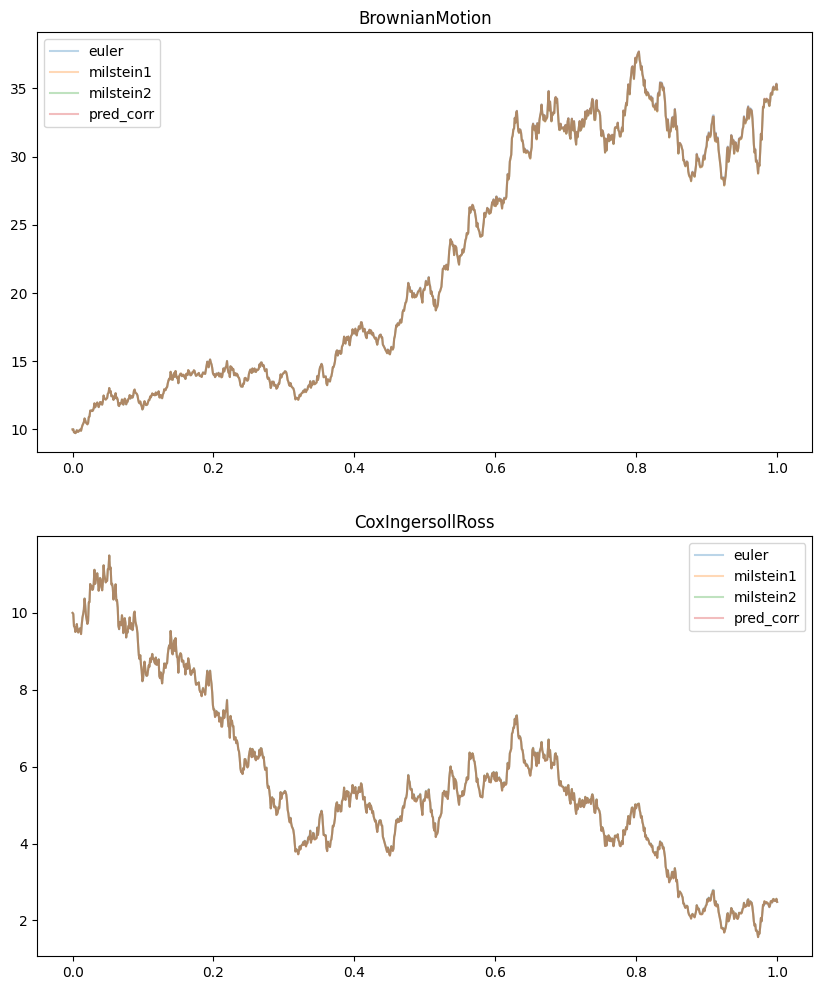

In [6]:
T = 1
N = 1000

ts, wieners = generate(T, N)

base_kwargs = {
    "end_t": T,
    "number_of_points": N,
    "wieners": wieners,
}

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

for model, ax in zip(models.values(), axes):
    kwargs = base_kwargs | { "model": model }
    for method_name, method in methods.items():
        ts, xt = method(kwargs)
        ax.plot(ts, xt, label=method_name, alpha=0.3)
    ax.set_title(f'{model.__class__.__name__}')
    ax.legend()

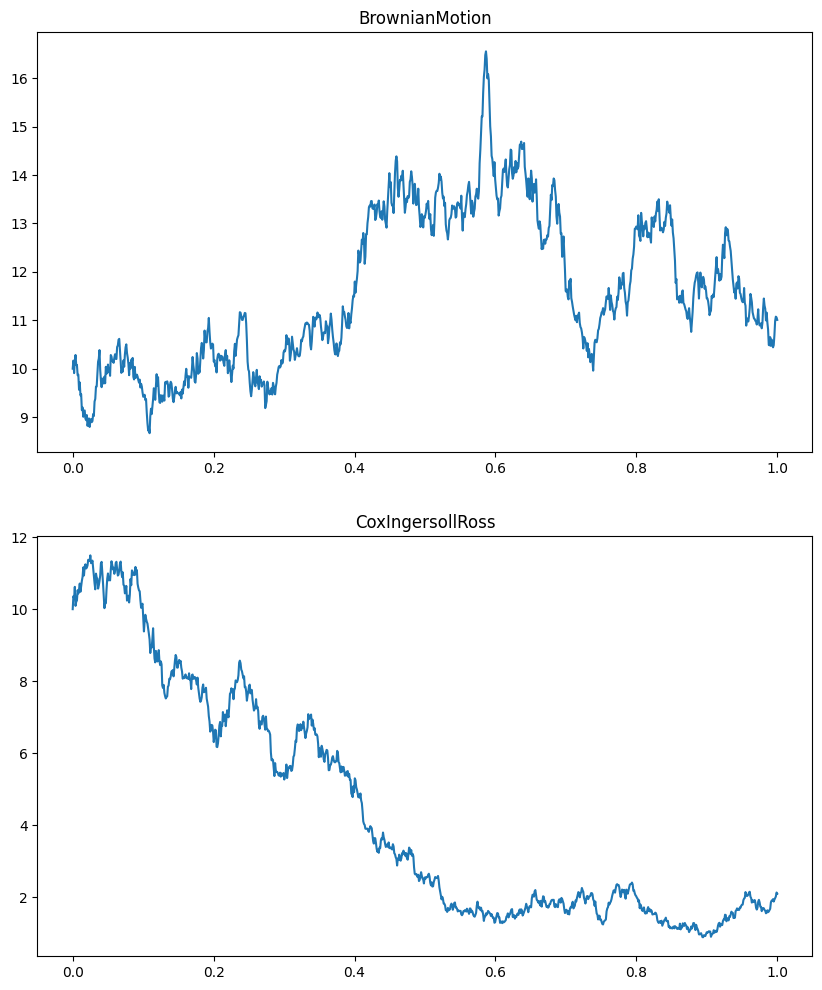

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
for model, ax in zip(models.values(), axes):
    ts, xt = kps_approximate(model, T, N)
    ax.plot(ts, xt)
    ax.set_title(model.__class__.__name__)

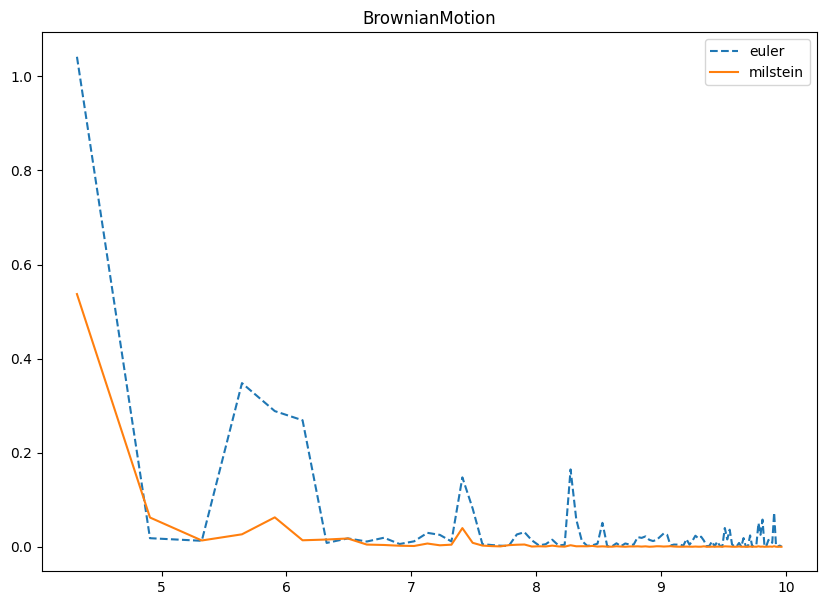

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

T = 1
model = brownian

ns = np.arange(20, 1001, 10, dtype=int)


euler_errors = []
milst_errors = []

for n in ns:
    _, wieners = generate(T, n)

    _, true_values = model.generate(T, n, wieners=wieners)
    _, euler = approximate(model, T, n, 'euler', wieners=wieners)
    _, milst = approximate(model, T, n, 'milstein2', wieners=wieners)
    euler_errors.append(((true_values - euler)**2).mean())
    milst_errors.append(((true_values - milst)**2).mean())

ax.plot(np.log2(ns), euler_errors, '--', label='euler')
ax.plot(np.log2(ns), milst_errors, '-', label='milstein')
ax.set_title(model.__class__.__name__)
ax.legend()

# RNG

In [9]:
from stochastic_simulation.random_number_generator import generate_from_rng

In [71]:
orn = OrnsteinUhlenbeck(10, 10, 5, 3.5)
brown = BrownianMotion(10, 1, 1/2)
cir = CoxIngersollRoss(10, 10, 5, 3.5)

mods = [orn, brown, cir]

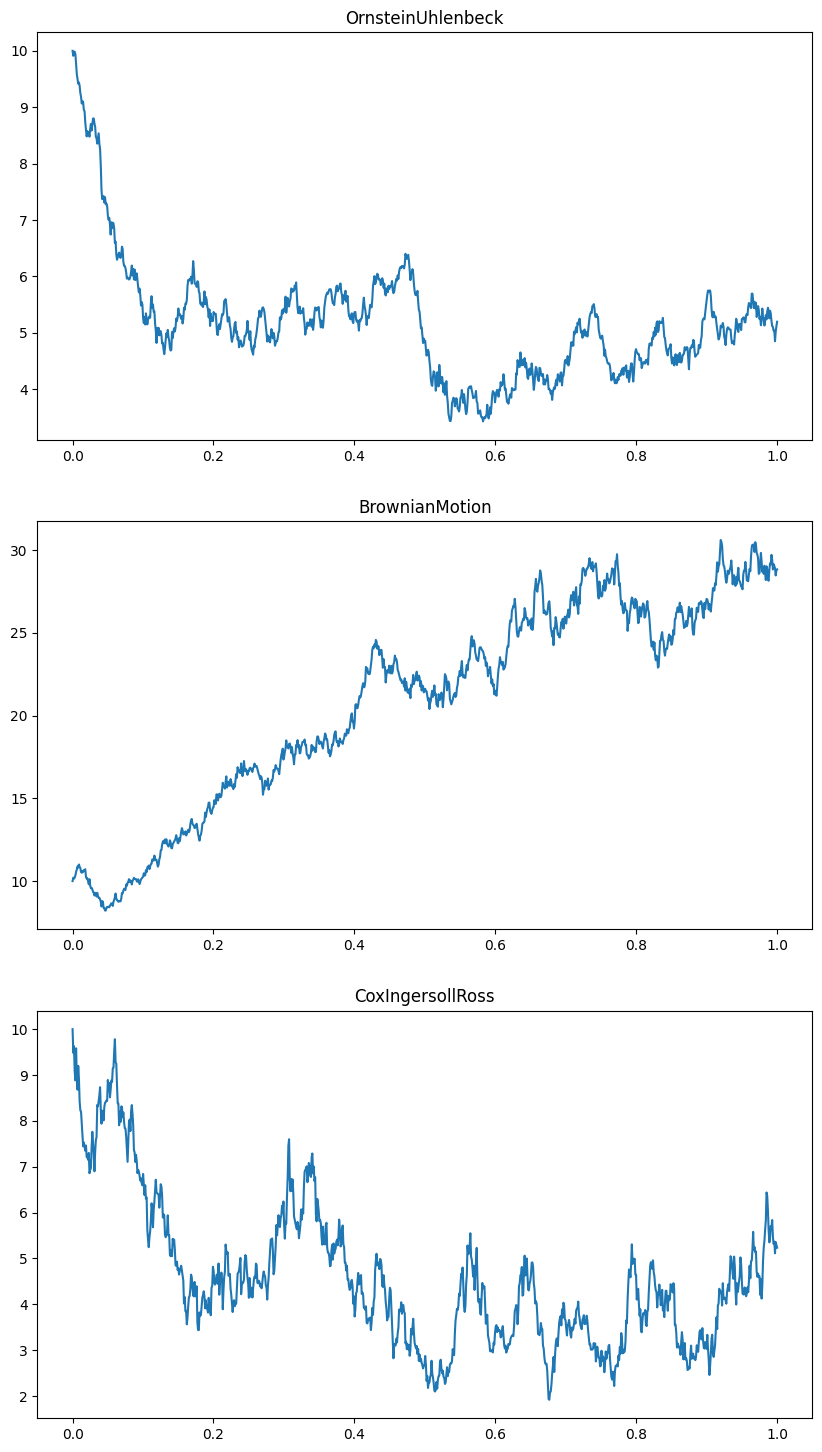

In [75]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for mod, ax in zip(mods, axes):
    ts, xt = generate_from_rng(mod.get_generator(), 1, 1000)
    ax.plot(ts, xt)
    name = mod.__class__.__name__
    ax.set_title(name)
    #np.savetxt(fname=f'{name}.txt', X=np.vstack([ts, xt]))

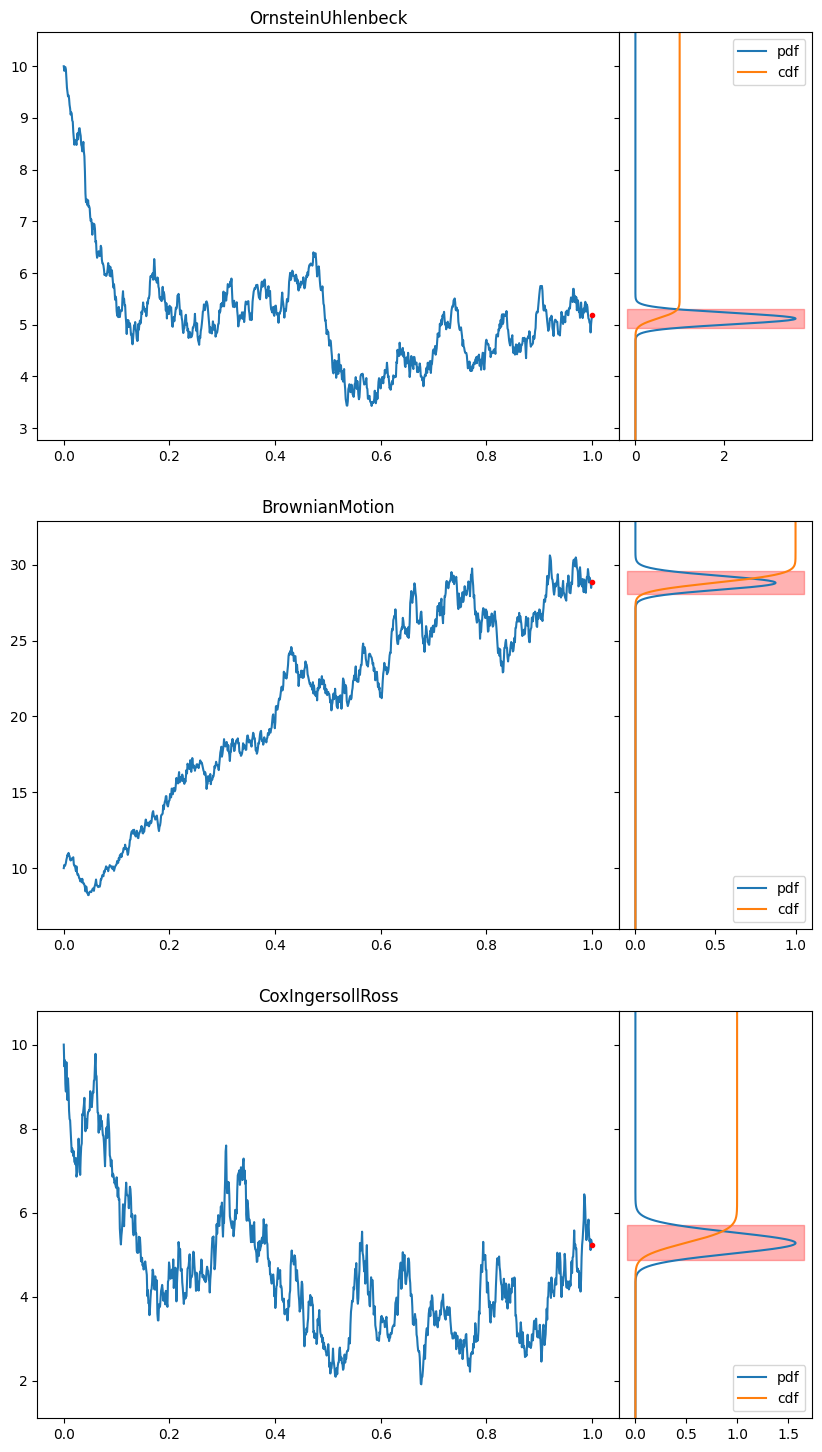

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(10, 18), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'wspace': 0})

for mod, ax_row in zip(mods, axes):
    name = mod.__class__.__name__
    ts, xt = np.loadtxt(f'{name}.txt')
    dt = ts[-1] - ts[-2]
    ax_row[0].plot(ts, xt)
    ax_row[0].plot(ts[-1], xt[-1], '.r')
    ax_row[0].set_title(name)
    xt_range = xt.max() - xt.min()
    xt_bounds = np.array([-1, 1]) * xt_range * 0.1
    xt_minmax = np.array([xt.min(), xt.max()])
    grid = np.linspace(*(xt_minmax + xt_bounds), 1000)
    ax_row[1].set_ylim(*(xt_minmax + xt_bounds))
    gen = mod.get_generator()
    ax_row[1].plot(gen.pdf(xt[-2], dt, grid), grid, label='pdf')
    ax_row[1].plot(gen.cdf(xt[-2], dt, grid), grid, label='cdf')
    
    upper, lower = gen.ppf(xt[-2], dt, 0.95), gen.ppf(xt[-2], dt, 0.05)
    ax_row[1].fill_between(ax_row[1].get_xlim(), upper, lower, color='red', alpha=0.3)
    ax_row[1].legend()


In [80]:
ornstein_stationary = sps.norm(loc=orn.mu, scale=(orn.sig / np.sqrt(orn.th * 2)))
cir_stationary = sps.gamma(2 * cir.th * cir.b / cir.sig**2, scale=(cir.sig**2/(2*cir.th)))

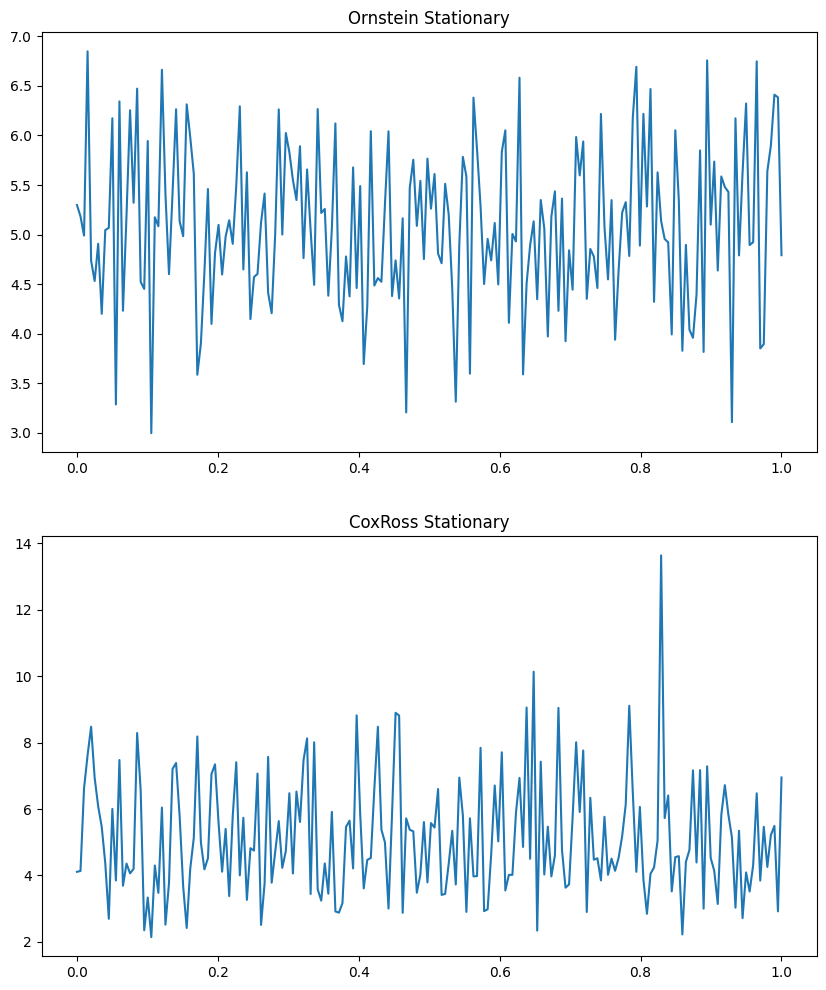

In [81]:
N = 200

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.set_title("Ornstein Stationary")
ax2.set_title("CoxRoss Stationary")

orn_stat_sample = ornstein_stationary.rvs(N)
cir_stat_sample = cir_stationary.rvs(N)

ts = np.linspace(0, 1, N)


ax1.plot(ts, orn_stat_sample)
ax2.plot(ts, cir_stat_sample)

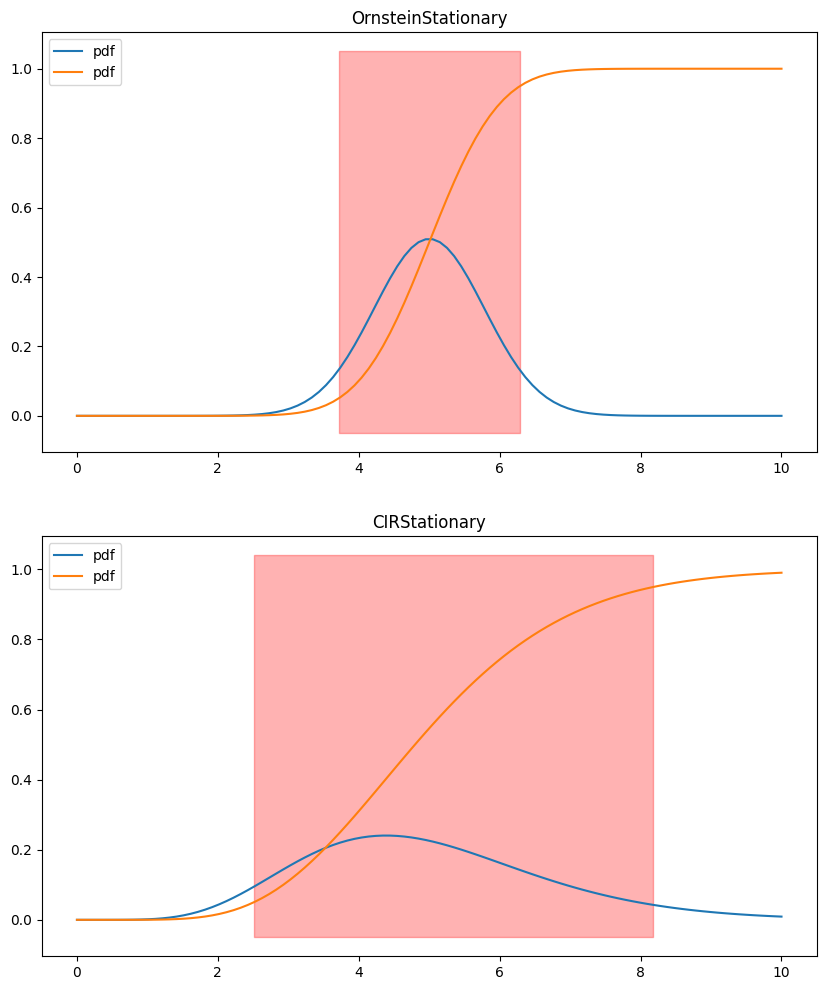

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.set_title("OrnsteinStationary")
ax2.set_title("CIRStationary")


x_grid = np.linspace(0, 10, 100)

for dist, ax in zip((ornstein_stationary, cir_stationary), (ax1, ax2)):
    ax.plot(x_grid, dist.pdf(x_grid), label='pdf')
    ax.plot(x_grid, dist.cdf(x_grid), label='pdf')
    upper, lower = dist.ppf(0.95), dist.ppf(0.05)
    ax.fill_between([upper, lower], *ax.get_ylim(), color='red', alpha=0.3)
    ax.legend()